# Physics-informed neural networks in Epidemiology - The SIR model

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Import needed packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

import torch
import torch.nn as nn
import torch.optim as optim

torch.set_default_dtype(torch.float64)

### Create some simulated data - it could be experimental data

In [3]:
from scipy.integrate import odeint

def sir_sim(z, t, a, mu):
    s, i = z
    dsdt = - a * s * i 
    didt =   a * s * i - mu * i
    return dsdt, didt


# time points
t_max = 10.0
t_steps = 100

t = np.linspace(0, t_max, t_steps)

a, mu = 0.0000005, 1

N = 10000000
z0 = (N-1, 1)

z = odeint(sir_sim, z0, t, args = (a,mu))

data = z[:,1]

noise_mean, noise_std = 0.0, 0.05
data_noisy = data*(1 + np.random.normal(noise_mean, noise_std, size=(t_steps)))/N

data /= N

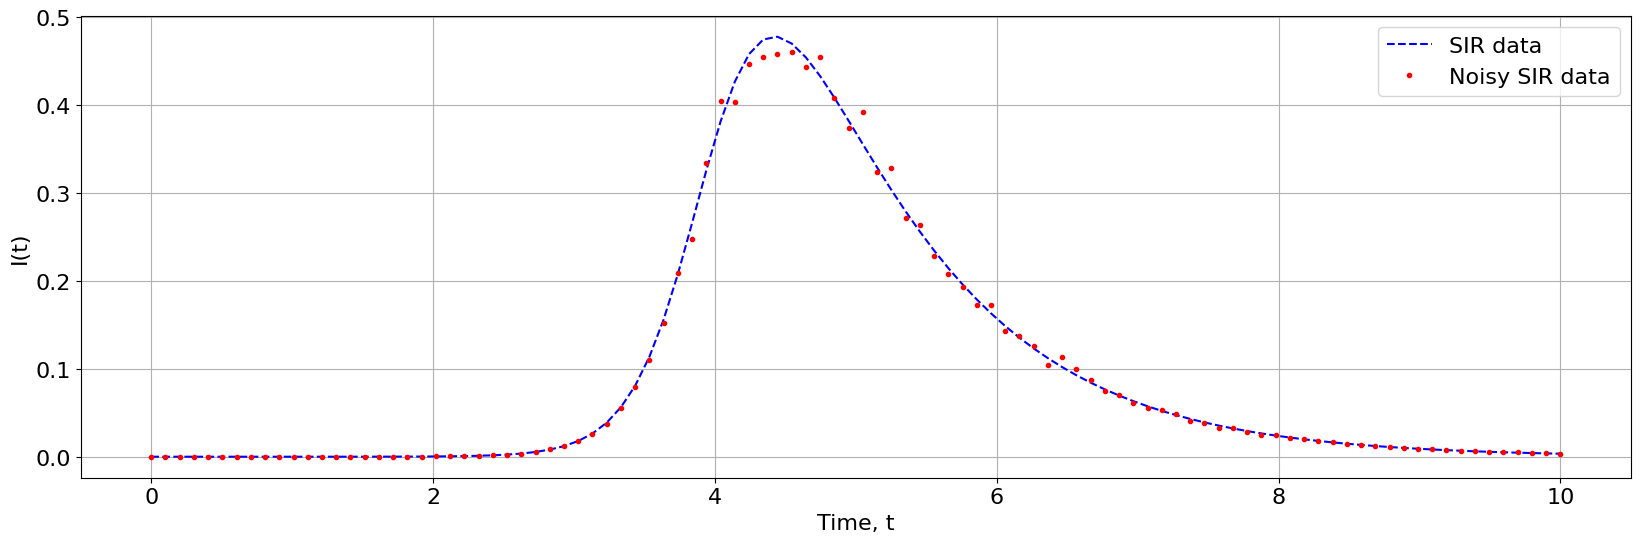

In [4]:
# plot results
fig = plt.figure(figsize = (20,6))

plt.plot(t, data,  'b--', label = "SIR data")
plt.plot(t, data_noisy,  'r.', label = "Noisy SIR data")

plt.xlabel("Time, t")
plt.ylabel("I(t)")

plt.legend()
plt.grid()
plt.show()

### Built the model

In [5]:
class SIR_PINN(nn.Module):
    
    def __init__(self):
        super(SIR_PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 100),  # Input layer: 1 input (t) to 64 neurons
            nn.Sigmoid(),
            nn.Linear(100, 100), # Hidden layer
            nn.Sigmoid(),
            nn.Linear(100, 100), # Hidden layer
            nn.Sigmoid(),
            nn.Linear(100, 100), # Hidden layer
            nn.Sigmoid(),
            nn.Linear(100, 100), # Hidden layer
            nn.Sigmoid(),
            nn.Linear(100, 1)   # Output layer: 1 output (infectious x)        
        )

    def forward(self, t):
        x = self.model(t.reshape(-1,1))
        return x

In [6]:
def sir_loss_fn(model, t, sigma0, sigma, mu):
    
    x = model(t)
    x_t  = torch.autograd.grad(x,   t, grad_outputs=torch.ones_like(x),   create_graph=True)[0]
    x_tt = torch.autograd.grad(x_t, t, grad_outputs=torch.ones_like(x_t), create_graph=True)[0]
    
    alpha = sigma0 + sigma*t
    residual = x_tt + (alpha * torch.exp(x) - sigma/alpha)*(x_t + mu)
    
    return torch.mean(residual ** 2)

In [7]:
def train_pinn(model, criterion, optimizer, t_train, t_data, y_data, sigma0, sigma, mu, epochs, use_sir):
    
    losses = []
    for epoch in range(1, epochs + 1):
        
        optimizer.zero_grad()
        
        loss_mse = criterion(torch.exp(model(t_data).flatten()), torch.exp(y_data))
        loss = loss_mse
        if use_sir:
            loss_sir = sir_loss_fn(model, t_train, sigma0, sigma, mu)
            loss = loss_mse + loss_sir
            
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch == 1 or epoch % 1000 == 0 or epoch == epochs:
            message = f"Epoch: {epoch:5d}, Loss: {loss.item():8.4f}, Loss MSE: {loss_mse.item():8.4f}"
            if use_sir:
                message += f" Loss SIR: {loss_sir.item():8.4f}"
            print(message)
            
    return losses

In [8]:
def plot_results(t_train, x_pred, t_data, y_data, losses, use_sir):
    
    plt.figure(figsize=(10, 4))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.yscale("log")
    plt.show()

    plt.figure(figsize=(20,6))
    plt.title("With SIR" if use_sir else "Without SIR")
    plt.plot(t_data.detach().numpy(), np.exp(y_data), 'r.', label="Real data")
    plt.plot(t_train.detach().numpy(), np.exp(x_pred.detach().numpy().flatten()), 'b--', label="Predicted")
    plt.xlabel("Time (t)")
    plt.ylabel("I(t)")
    plt.legend()
    plt.show()

In [9]:
# Define the parameters and data
torch.manual_seed(42)
np.random.seed(42)

sigma0 = torch.rand(1, 1, requires_grad=True)
sigma =  torch.rand(1, 1, requires_grad=True)
mu = torch.rand(1, 1, requires_grad=True)

N_data_points = int(0.55*t_steps)
t_data = torch.from_numpy(t[:N_data_points])
y_data = torch.log(torch.from_numpy(data_noisy[:N_data_points]))

t_train = torch.linspace(0, 10, 1000, requires_grad=True)

In [10]:
print(f"a(t) = {sigma0.detach().numpy().flatten()[0]:.3f} + {sigma.detach().numpy().flatten()[0]:.3f}t")
print(f"mu = {mu.detach().numpy().flatten()[0]:.3f}")

a(t) = 0.058 + 0.063t
mu = 0.124


In [11]:
# Initialize the model and define the optimizer
torch.manual_seed(42)
np.random.seed(42)

model = SIR_PINN()

criterion = torch.nn.MSELoss(reduction='sum')

optimizer = optim.Adam([{'params': model.parameters(), 'lr': 1e-3},
                        {'params': sigma0, 'lr': 1e-3},
                        {'params': sigma, 'lr': 1e-3},
                        {'params': mu, 'lr': 1e-3}])

In [12]:
use_sir = True

epochs = 10000

# Train the model
losses = train_pinn(model, criterion, optimizer, t_train, t_data, y_data, sigma0, sigma, mu, epochs, use_sir)

Epoch:     1, Loss:  54.8617, Loss MSE:  54.8590 Loss SIR:   0.0026
Epoch:  1000, Loss:   0.3197, Loss MSE:   0.2412 Loss SIR:   0.0785
Epoch:  2000, Loss:   0.2780, Loss MSE:   0.2009 Loss SIR:   0.0771
Epoch:  3000, Loss:   0.2709, Loss MSE:   0.1878 Loss SIR:   0.0832
Epoch:  4000, Loss:   0.2661, Loss MSE:   0.1711 Loss SIR:   0.0950
Epoch:  5000, Loss:   0.2642, Loss MSE:   0.1643 Loss SIR:   0.1000
Epoch:  6000, Loss:   0.2631, Loss MSE:   0.1630 Loss SIR:   0.1001
Epoch:  7000, Loss:   0.2623, Loss MSE:   0.1614 Loss SIR:   0.1009
Epoch:  8000, Loss:   0.2623, Loss MSE:   0.1622 Loss SIR:   0.1001
Epoch:  9000, Loss:   0.2622, Loss MSE:   0.1618 Loss SIR:   0.1005
Epoch: 10000, Loss:   0.2622, Loss MSE:   0.1616 Loss SIR:   0.1007


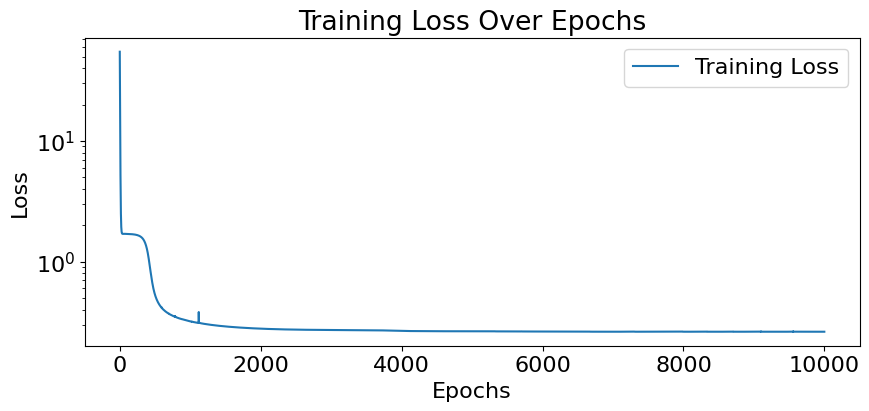

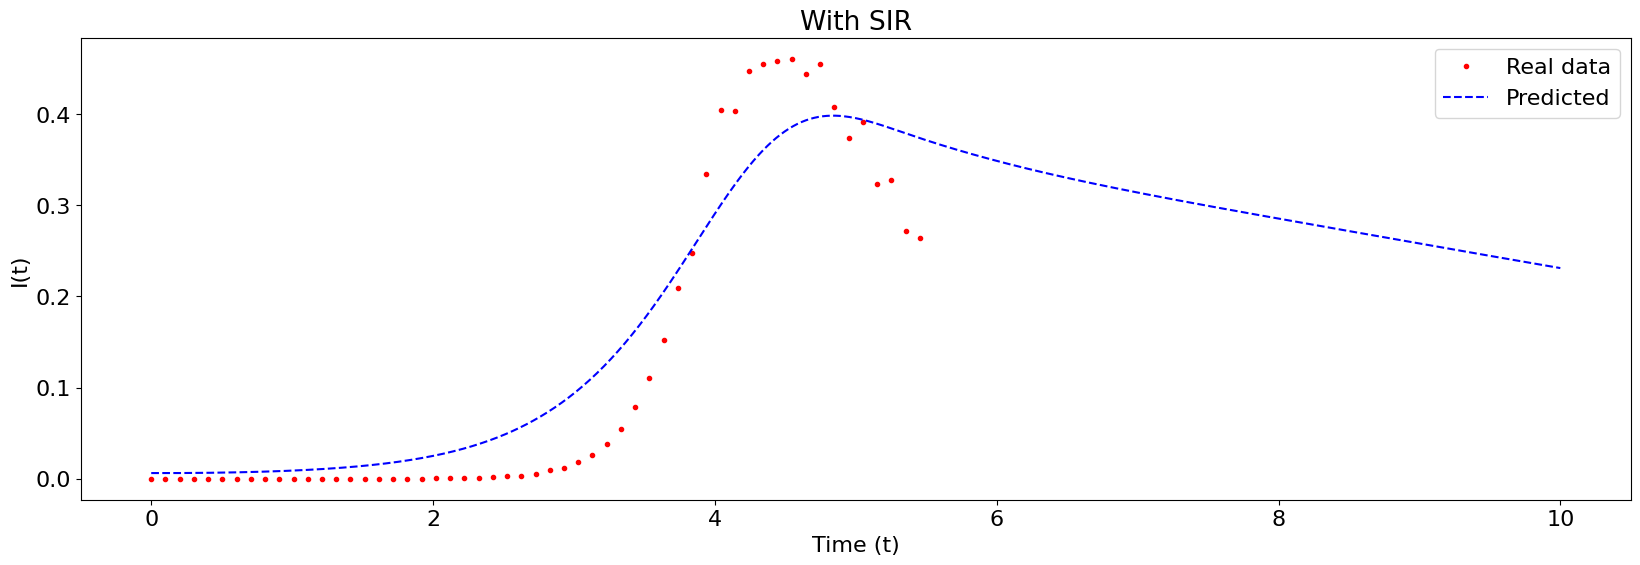

In [13]:
# Plot the results
x_pred = model(t_train)
plot_results(t_train, x_pred, t_data, y_data, losses, use_sir)

In [14]:
print(f"a(t) = {sigma0.detach().numpy().flatten()[0]:.3f} + {sigma.detach().numpy().flatten()[0]:.3f}t")
print(f"mu = {mu.detach().numpy().flatten()[0]:.3f}")

a(t) = 0.040 + 0.655t
mu = 0.119


### Train without the SIR model - Supervised, data driven approach

In [15]:
torch.manual_seed(42)
np.random.seed(42)

model = SIR_PINN()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr= 1e-3)

use_sir = False

epochs = 10000
losses = train_pinn(model, criterion, optimizer, t_train, t_data, y_data, sigma0, sigma, mu, epochs, use_sir)

Epoch:     1, Loss:  54.8590, Loss MSE:  54.8590
Epoch:  1000, Loss:   0.0955, Loss MSE:   0.0955
Epoch:  2000, Loss:   0.0705, Loss MSE:   0.0705
Epoch:  3000, Loss:   0.0056, Loss MSE:   0.0056
Epoch:  4000, Loss:   0.0038, Loss MSE:   0.0038
Epoch:  5000, Loss:   0.0029, Loss MSE:   0.0029
Epoch:  6000, Loss:   0.0022, Loss MSE:   0.0022
Epoch:  7000, Loss:   0.0018, Loss MSE:   0.0018
Epoch:  8000, Loss:   0.0011, Loss MSE:   0.0011
Epoch:  9000, Loss:   0.0003, Loss MSE:   0.0003
Epoch: 10000, Loss:   0.0002, Loss MSE:   0.0002


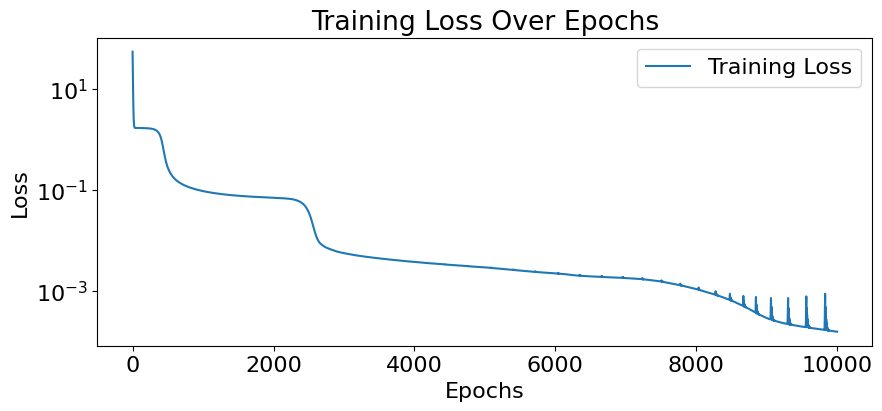

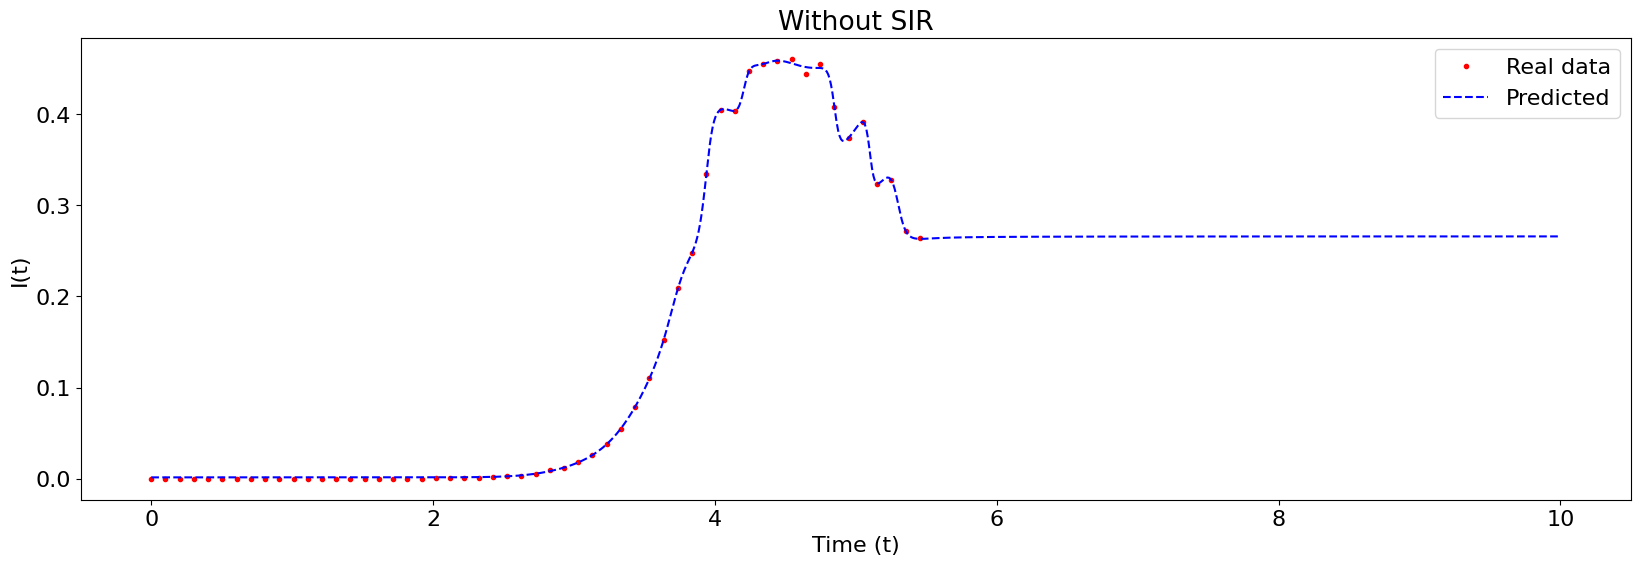

In [16]:
x_pred = model(t_train)
plot_results(t_train, x_pred, t_data, y_data, losses, use_sir)